<a href="https://colab.research.google.com/github/Pratham-04/CS786A-Spring-2020-21/blob/main/Project/Prob_Explore.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pickle
import numpy as np
import pandas as pd
import io
from scipy.stats.mvn import mvnun
import matplotlib.pyplot as plt
import json

In [ ]:
with open('/content/drive/My Drive/1.pkl', 'rb') as f:
    params_dec_smf = pickle.load(f)

with open('/content/drive/My Drive/2.pkl', 'rb') as f:
    params_del_smd = pickle.load(f)

with open('/content/drive/My Drive/3.pkl', 'rb') as f:
    params_kf_pmu = pickle.load(f)

In [ ]:
def makeRew(trend, stable, clip, numTrials, s):
    # generates the game and returns those where each bandit is the best at least once
    np.random.seed(s)
    
    # initializations
    mus = []
    rews = []
    mu = np.array([-60, -20, 20, 60])
    np.random.shuffle(mu)
    mus.append(mu)
    sigma1 = 4
    decay = 0.9836
    
    # trend
    kappas = np.zeros(4)
    if trend == 1:
        kappas[mu > 0] = -0.5
        kappas[mu < 0] = 0.5

    # stable/variable            
    sigma2 = 4        
    rews.append(np.random.normal(mu, sigma2))           
    for i in range(numTrials - 1):
        if stable == 0 and (51<=i<=100 or 151<=i<=200):
            sigma2 = 16
        else:
            sigma2 = 4
        mu = np.multiply(mu, decay)
        mu = np.add(mu, kappas)
        mu = np.random.normal(mu, sigma2)
        if clip == 1:
            mu = np.clip(mu, -100, 100)
        mus.append(mu)
        
        rew = np.random.normal(mu, sigma1)
        if clip == 1:
            rew = np.clip(rew, -100, 100)
        rews.append(rew)
    np.random.seed(None)
    maxs = np.argmax(rews, 1)
    if ((0 in maxs) and (1 in maxs) and (2 in maxs) and (3 in maxs)):
        return np.array(mus), np.array(rews)
    else:
        return None, None

In [ ]:
# utility from prospect theory

def util(r, lamb, alpha):
    # print(r)
    u = np.copy(r)
    u[r >= 0] = u[r >= 0]**alpha
    u[r < 0] = -lamb*((-u[r < 0])**alpha)
    return u

In [ ]:
# choice rules

def dyn_softmax(x, temp0, i):
    temp = ((i+1)/10)**temp0
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def softmax(x, temp):
    return np.exp(np.multiply(x,temp))/np.sum(np.exp(np.multiply(x,temp)))

def pmu(x_mean, x_var, sigma_eps):
    prob = -1*np.ones(4)
    for i in range(4):
        A = -1*np.identity(3)
        A = np.insert(A, i, np.array([1,1,1]), 1)
        M = np.matmul(A, x_mean)
        H = np.diag(x_var + sigma_eps**2)
        H = np.matmul(np.matmul(A, H), np.transpose(A))
        prob[i] = mvnun([0,0,0], [np.inf,np.inf,np.inf], M, H)[0]
    return prob/np.sum(prob)

In [ ]:
# learning rules

def delta(x, rew, choice, eta, lamb, alpha):
    if choice == -1:
        return x
    lr = np.zeros(4)
    lr[choice] = eta
    return x + np.multiply(lr, util(rew, lamb, alpha) - x)

def decay(x, rew, choice, eta_dec, lamb, alpha):
    if choice == -1:
        return eta_dec*x
    y = np.zeros(4)
    y[choice] = 1
    return eta_dec*x + np.multiply(y, util(rew, lamb, alpha))

def kalman(x_mean, x_var, rew, choice, sigma_xi, sigma_eps, lamb, alpha):
    if choice == -1:
        return x_mean, x_var + sigma_xi**2
    k_gain = np.zeros(4)
    k_gain[choice] = (x_var[choice] + sigma_xi**2)/(x_var[choice] + sigma_xi**2 + sigma_eps**2)
    x_mean1 = x_mean + np.multiply(k_gain, util(rew, lamb, alpha) - x_mean)
    x_var1 = np.multiply(1 - k_gain, x_var + sigma_xi**2)
    return x_mean1, x_var1

In [ ]:
def del_dsm_prob(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    temp0 = param[0]
    mu0 = param[1]
    eta = param[2]
    lamb = param[3]
    alpha = param[4]
    m = mu0*np.ones((numTrials + 1, 4))
    probs = np.ma.masked_all(200)
    maxs = np.argmax(rews, 1)
    for i in range(numTrials):
        prob = dyn_softmax(m[i], temp0, i)
        if chosen_idx[i] == -1:
            probs[i] = np.ma.masked
        else:
            probs[i] = 1-prob[int(maxs[i])]
        m[i+1] = delta(m[i], rews[i], int(chosen_idx[i]), eta, lamb, alpha)
        # if chosen_idx[i] == np.ma.masked:
        #     probs[i] = np.ma.masked
        #     m[i+1] = m[i]
        # else:
        #     prob = dyn_softmax(m[i], temp0, i)
        #     probs[i] = 1 - prob[int(maxs[i])]
        #     m[i+1] = delta(m[i], rews[i], int(chosen_idx[i]), eta, lamb, alpha)
    return probs

def dec_fsm_prob(param, rews, chosen_idx):
    temp = param[0]
    mu0 = param[1]
    eta_dec = param[2]
    lamb = param[3]
    alpha = param[4]
    numTrials = rews.shape[0]
    m = mu0*np.ones((numTrials+1, 4))
    probs = np.ma.masked_all(200)
    maxs = np.argmax(rews, 1)
    for i in range(numTrials):
        prob = softmax(m[i], temp)
        if chosen_idx[i] == -1:
            probs[i] = np.ma.masked
        else:
            probs[i] = 1 - prob[int(maxs[i])]
        m[i+1] = decay(m[i], rews[i], int(chosen_idx[i]), eta_dec, lamb, alpha)
    return probs

def kf_pmu_prob(param, rews, chosen_idx):
    numTrials = rews.shape[0]
    mu0 = param[0]
    sigma0 = param[1]
    sigma_xi = param[2]
    sigma_eps = param[3]
    lamb = param[4]
    alpha = param[5]
    m = mu0*np.ones((numTrials + 1, 4))
    v = sigma0*np.ones((numTrials + 1, 4))
    probs = np.ma.masked_all(200)
    maxs = np.argmax(rews, 1)
    for i in range(numTrials):
        prob = pmu(m[i], v[i], sigma_eps)
        if chosen_idx[i] == -1:
            probs[i] = np.ma.masked
            # print(i)
            # print(probs[i])
        else:
            probs[i] = 1 - prob[int(maxs[i])]
            # print(i)
            # print(probs[i])
        # print(i)
        # print(probs[i])
        m[i+1], v[i+1] = kalman(m[i], v[i], rews[i], int(chosen_idx[i]), sigma_xi, sigma_eps, lamb, alpha)
    return probs

In [ ]:
# trend, stable
numTrials = 200
m000, r000 = makeRew(0, 0, 0, numTrials, 207)
m001, r001 = makeRew(0, 0, 0, numTrials, 368)
m010, r010 = makeRew(0, 1, 0, numTrials, 82)
m011, r011 = makeRew(0, 1, 0, numTrials, 411)
m100, r100 = makeRew(1, 0, 0, numTrials, 49)
m101, r101 = makeRew(1, 0, 0, numTrials, 67)
m110, r110 = makeRew(1, 1, 0, numTrials, 75)
m111, r111 = makeRew(1, 1, 0, numTrials, 287)

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving 32.csv to 32 (1).csv
Saving 41.csv to 41 (1).csv
Saving 51.csv to 51 (1).csv
Saving 52.csv to 52.csv
Saving 57.csv to 57.csv
Saving 63.csv to 63.csv
Saving 73.csv to 73.csv
Saving 76.csv to 76.csv
Saving 81.csv to 81.csv
Saving 85.csv to 85.csv
Saving 86.csv to 86.csv
Saving 90.csv to 90.csv
Saving 91.csv to 91.csv
Saving 98.csv to 98.csv
Saving 99.csv to 99.csv
Saving 125.csv to 125.csv
Saving 139.csv to 139.csv
Saving 140.csv to 140.csv
Saving 143.csv to 143.csv
Saving 148.csv to 148.csv
Saving 149.csv to 149.csv
Saving 150.csv to 150.csv
Saving 152.csv to 152.csv
Saving 156.csv to 156.csv
Saving 159.csv to 159.csv
Saving 161.csv to 161.csv
Saving 163.csv to 163.csv
Saving 169.csv to 169.csv
Saving 170.csv to 170.csv
Saving 178.csv to 178.csv


In [ ]:
probs1 = []
probs2 = []
probs3 = []
trends = []
stables = []
ages = []
sexs = []
hands = []

j = 0

for i in range(200):
    if (str(i) + '.csv') in uploaded:
        df = pd.read_csv(io.BytesIO(uploaded[str(i) + '.csv']))
        if df.shape[0] > 575:
            print(i)
            
            trend = df['trend'][1]
            trends.append(trend)
            stable = df['stable'][1]
            stables.append(stable)
            num = df['num'][1]
            resp_map = eval(df['resp_map'][1])

            pinfo = json.loads(df['response'][0])
            age = pinfo['age']
            ages.append(age)
            sex = pinfo['sex']
            sexs.append(sex)
            hand = pinfo['hand']
            hands.append(hand)

            chosen_idx = df['response']
            chosen_idx = chosen_idx.iloc[6:df.shape[0]]
            chosen_idx = chosen_idx[[i for i in range(6, df.shape[0], 3)]]
            chosen_idx[chosen_idx == 'q'] = resp_map[0]
            chosen_idx[chosen_idx == 'p'] = resp_map[1]
            chosen_idx[chosen_idx == 'm'] = resp_map[2]
            chosen_idx[chosen_idx == 'z'] = resp_map[3]
            chosen_idx[pd.isna(chosen_idx)] = -1
            chosen_idx = np.array(chosen_idx)

            rews = eval('r' + str(trend) + str(stable) + str(num))
            rews = rews[0:chosen_idx.shape[0],:]

            prob1 = del_dsm_prob(params_del_smd[j], rews, chosen_idx)
            # if len(np.where(prob1>1)[0])>0:
            #     print('1')
            #     print(j, i)
            #     print(np.where(prob1>1))
            #     break
            prob2 = dec_fsm_prob(params_dec_smf[j], rews, chosen_idx)
            # if len(np.where(prob2>1)[0])>0:
            #     print('2')
            #     print(j, i)
            #     break
            prob3 = kf_pmu_prob(params_kf_pmu[j], rews, chosen_idx)
            # if len(np.where(prob3>1)[0])>0:
            #     print('3')
            #     print(j, i)
            #     break
            # print(prob3[171])
            j += 1

            probs1.append(prob1)
            probs2.append(prob2)
            probs3.append(prob3)

probs1 = np.ma.array(probs1)
probs2 = np.ma.array(probs2)
probs3 = np.ma.array(probs3)
trends = np.array(trends)
stables = np.array(stables)

32
41
51
52
57
63
73
76
81
85
86
90
91
98
99
125
139
140
143
148
149
150
152
156
159
161
163
169
170
178


In [ ]:
# del_dsm, dec_fsm, kf_pmu
sn_del = []
sn_dec = []
sn_kf = []
st_del = []
st_dec = []
st_kf = []
vn_del = []
vn_dec = []
vn_kf = []
vt_del = []
vt_dec = []
vt_kf = []
for i in range(30):
    if trends[i] == '0' and stables[i] == '0':
        vn_del.append(probs1[i])
        vn_dec.append(probs2[i])
        vn_kf.append(probs3[i])
    elif trends[i] == '0' and stables[i] == '1':
        sn_del.append(probs1[i])
        sn_dec.append(probs2[i])
        sn_kf.append(probs3[i])
    elif trends[i] == '1' and stables[i] == '0':
        vt_del.append(probs1[i])
        vt_dec.append(probs2[i])
        vt_kf.append(probs3[i])
    elif trends[i] == '1' and stables[i] == '1':
        st_del.append(probs1[i])
        st_dec.append(probs2[i])
        st_kf.append(probs3[i])

sn_del = np.mean(sn_del, 0)
sn_dec = np.mean(sn_dec, 0)
sn_kf = np.mean(sn_kf, 0)
st_del = np.mean(st_del, 0)
st_dec = np.mean(st_dec, 0)
st_kf = np.mean(st_kf, 0)
vn_del = np.mean(vn_del, 0)
vn_dec = np.mean(vn_dec, 0)
vn_kf = np.mean(vn_kf, 0)
vt_del = np.mean(vt_del, 0)
vt_dec = np.mean(vt_dec, 0)
vt_kf = np.mean(vt_kf, 0)

Text(0.04, 0.5, 'p(exploration)')

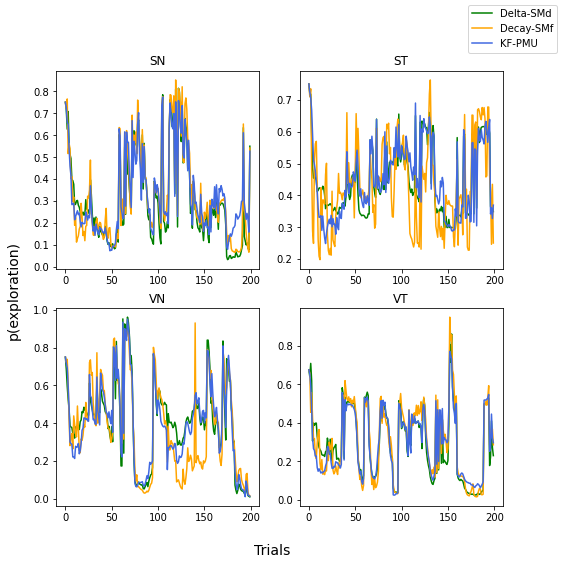

In [ ]:
fig, axs = plt.subplots(nrows = 2, ncols = 2, figsize = (8, 8))
line_labels = ['Delta-SMd', 'Decay-SMf', 'KF-PMU' ]

axs[0, 0].plot(sn_del, color = 'green')
axs[0, 0].plot(sn_dec, color = 'orange')
axs[0, 0].plot(sn_kf, color = 'royalblue')
axs[0, 0].set_title('SN')
axs[0, 1].plot(st_del, color = 'green')
axs[0, 1].plot(st_dec, color = 'orange')
axs[0, 1].plot(st_kf, color = 'royalblue')
axs[0, 1].set_title('ST')
axs[1, 0].plot(vn_del, color = 'green')
axs[1, 0].plot(vn_dec, color = 'orange')
axs[1, 0].plot(vn_kf, color = 'royalblue')
axs[1, 0].set_title('VN')
axs[1, 1].plot(vt_del, color = 'green')
axs[1, 1].plot(vt_dec, color = 'orange')
axs[1, 1].plot(vt_kf, color = 'royalblue')
axs[1, 1].set_title('VT')

fig.legend(labels = line_labels)
fig.text(0.5, 0.04, 'Trials', ha = 'center', fontsize = 14)
fig.text(0.04, 0.5, 'p(exploration)', va='center', rotation='vertical', fontsize = 14)



